# Leverage by Short-Selling

The *standard mean-variance (Markowitz) portfolio selection model* determines an optimal investment portfolio that balances risk and expected return. In this notebook, we maximize the portfolio's expected return while constraining the admissible variance (risk) to a given maximum level. Please refer to the [annotated list of references](../literature.rst#portfolio-optimization) for more background information on portfolio optimization.

This notebook adds *leverage* and *short-selling* to this basic model.
In short-selling, assets are borrowed and sold, with the intention of repurchasing them later at a lower price. This augments traditional long-only investing by taking advantage of both rising and falling prices.
Leverage means using borrowed capital as a funding source to increase the potential return.

In the 130/30 investment strategy, a ratio of up to 130% of the starting capital is allocated to long positions. This is accomplished by short-selling up to 30% of the starting capital.

In [1]:
# Install dependencies
%pip install numpy scipy gurobipy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import gurobipy as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Hidden cell to avoid licensing messages
# when docs are generated.
with gp.Model():
    pass

Set parameter WLSAccessID


Set parameter WLSSecret


Set parameter LicenseID to value 2443533


WLS license 2443533 - registered to Gurobi GmbH


## Input Data

The following input data is used within the model:

- $S$: set of stocks
- $\mu$: vector of expected returns
- $\Sigma$: PSD variance-covariance matrix
    - $\sigma_{ij}$ covariance between returns of assets $i$ and $j$
    - $\sigma_{ii}$ variance of return of asset $i$

In [4]:
# Import some example data set
Sigma = pd.read_pickle("sigma.pkl")
mu = pd.read_pickle("mu.pkl")

## Formulation
Mathematically, this results in a convex quadratically constrained optimization problem.

### Model Parameters

The following parameters are used within the model:

- $\bar\sigma^2$: maximal admissible variance for the portfolio return
- $s_\text{total}$: maximal total short ratio allowed
- $s_i$: maximal short ratio for asset $i$
- $\ell_i$: maximal long ratio (i.e., position size) for asset $i$

To model a 130/30-portfolio, we will use $s_\text{total}=0.3$ in our example. In this strategy, we use the cash from short-selling to buy assets on the long side.

In [5]:
# Values for the model parameters:
V = 4.0  # Maximal admissible variance (sigma^2)
s_total = 0.3  # Maximal short ratio

s = 0.1 * np.ones(mu.shape)  # Maximal short per asset
l = 0.2 * np.ones(mu.shape)  # Maximal long per asset

### Decision Variables
We need three sets of decision variables:

1. The proportions of capital invested among the considered stocks. The corresponding vector of positions is denoted by $x$ with its component $x_i$ denoting the proportion of capital invested in stock $i$. Since we allow short positions, $x_i$ may be negative.

The other sets split the position into long and short components:

2. The *long* proportions of each stock in the portfolio. The corresponding vector of long positions is denoted by $x^+$ with its component $x^+_i$ representing the long position in stock $i$.

3. The *short* proportions of each stock in the portfolio. The corresponding vector of short positions is denoted by $x^-$ with its component $x^-_i$ representing the short position in stock $i$.

### Variable Bounds

Each position must be between $-s_i$ and $\ell_i$:

$$-s_i\leq x_i\leq \ell_i \; , \;  i \in S$$

The long and short proportions must be non-negative:

$$ x_i^+, x_i^- \geq 0\; , \, i \in S$$

In [6]:
%%capture
# Create an empty optimization model
m = gp.Model()

# Add variables: x[i] denotes the proportion invested in stock i
x = m.addMVar(len(mu), lb=-s, ub=l, name="x")
# Add variables: x_plus[i] denotes the long proportion of stock i
x_plus = m.addMVar(len(mu), lb=0, name="x_plus")
# Add variables: x_minus[i] denotes the short proportion of stock i
x_minus = m.addMVar(len(mu), lb=0, name="x_minus")

###  Constraints

The budget constraint ensures that all capital is invested:
\begin{equation*}
\sum_{i \in S} x_i = 1
\end{equation*}

The proportion of capital invested is the difference between the positive and the negative parts:
\begin{equation*}
x_i = x^+_i - x^-_i \; , \; i \in S \tag{1}
\end{equation*}

The estimated risk must not exceed a prespecified maximal admissible level of variance $\bar\sigma^2$:
\begin{equation*}
x^\top \Sigma x \leq \bar\sigma^2
\end{equation*}

In [7]:
%%capture
# Budget constraint: all investments sum up to 1
budget_constr = m.addConstr(x.sum() == 1, name="Budget_Constraint")

# Position rebalancing constraint, see formula (1) above
m.addConstr(x == x_plus - x_minus, name="Position_Balance")

# Upper bound on variance
risk_constr = m.addConstr(x @ Sigma.to_numpy() @ x <= V, name="Variance")

#### Limiting Total Leverage and Short-Selling

We limit the total of the short positions:

\begin{equation*}
\sum_{i \in S} x^-_i \leq s_\text{total}\tag{2}
\end{equation*}

Note that in the optimal solution of the optimization problem, at least one of the two variables $x^+_i$ or $x^-_i$ is necessarily equal to zero for each asset $i$; this follows from the convexity of the problem. Generally though, if additional discrete constraints were added to the model, this complementarity is no longer guaranteed and more modeling care has to be taken; see [the notebook on transaction costs](transaction_costs.ipynb) for more details

In [8]:
%%capture
# Max short; see formula (2) above
short_constr = m.addConstr(x_minus.sum() <= s_total, name="Total_Short")

###  Objective Function
The objective is to maximize the expected return of the portfolio:
$$\max_x \mu^\top x $$

In [9]:
m.setObjective(mu.to_numpy() @ x, gp.GRB.MAXIMIZE)

We now solve the optimization problem:

In [10]:
m.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 22.04.4 LTS")


CPU model: AMD EPYC 7763 64-Core Processor, instruction set [SSE2|AVX|AVX2]


Thread count: 1 physical cores, 2 logical processors, using up to 2 threads


WLS license 2443533 - registered to Gurobi GmbH


Optimize a model with 464 rows, 1386 columns and 2310 nonzeros


Model fingerprint: 0x5705a198


Model has 1 quadratic constraint


Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


  QMatrix range    [3e-03, 1e+02]


  Objective range  [7e-02, 6e-01]


  Bounds range     [1e-01, 2e-01]


  RHS range        [3e-01, 1e+00]


  QRHS range       [4e+00, 4e+00]


Presolve removed 0 rows and 462 columns


Presolve time: 0.05s


Presolved: 927 rows, 1387 columns, 109264 nonzeros


Presolved model has 1 second-order cone constraint


Ordering time: 0.01s


Barrier statistics:


 AA' NZ     : 2.153e+05


 Factor NZ  : 2.423e+05 (roughly 3 MB of memory)


 Factor Ops : 9.108e+07 (less than 1 second per iteration)


 Threads    : 1


                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.09530770e+01  6.63152811e+01  4.62e+01 5.22e-01  6.75e-02     0s


   1   1.06683696e+00  1.01784355e+01  3.23e+00 2.60e-03  5.81e-03     0s


   2   3.13698670e-01  1.45958398e+00  1.72e-01 1.43e-04  5.68e-04     0s


   3   3.32627798e-01  8.43175671e-01  5.01e-02 5.74e-05  2.36e-04     0s


   4   3.33107237e-01  6.88708709e-01  1.04e-02 3.53e-05  1.56e-04     0s


   5   3.77330169e-01  5.62141009e-01  1.45e-05 1.80e-05  8.00e-05     0s


   6   4.10777104e-01  4.65400413e-01  8.00e-07 5.13e-06  2.36e-05     0s


   7   4.18189425e-01  4.32791130e-01  1.91e-12 1.46e-06  6.32e-06     0s


   8   4.20353188e-01  4.23676729e-01  1.61e-12 3.92e-07  1.44e-06     0s


   9   4.20528316e-01  4.20638414e-01  1.29e-12 7.80e-09  4.76e-08     0s


  10   4.20558431e-01  4.20559964e-01  3.25e-12 9.27e-11  6.63e-10     0s


  11   4.20558886e-01  4.20558929e-01  4.13e-10 4.79e-13  1.84e-11     0s


Barrier solved model in 11 iterations and 0.39 seconds (0.75 work units)


Optimal objective 4.20558886e-01


Display basic solution data for all non-negligible positions; for clarity we've rounded all solution quantities to five digits.

In [11]:
print(f"Expected return: {m.ObjVal:.6f}")
print(f"Variance:        {x.X @ Sigma @ x.X:.6f}")
print(f"Solution time:   {m.Runtime:.2f} seconds\n")
print(f"Total long:      {x.X[x.X>1e-5].sum():.6f}")
print(f"Total short:     {-x.X[x.X<-1e-5].sum():.6f}")

print(f"Number of positions: {np.count_nonzero(x.X[abs(x.X)>1e-5])}")
print(f"               long: {np.count_nonzero(x.X[x.X>1e-5])}")
print(f"              short: {np.count_nonzero(x.X[x.X<-1e-5])}")

# Print all assets with a non-negligible position
df = pd.DataFrame(
    index=mu.index,
    data={
        "x": x.X,
        "x_plus": x_plus.X,
        "x_minus": x_minus.X,
    },
).round(6)
df[(abs(df["x"]) > 1e-5)].sort_values("x", ascending=False)

Expected return: 0.420559
Variance:        4.000000
Solution time:   0.40 seconds

Total long:      1.299989
Total short:     0.299994
Number of positions: 37
               long: 27
              short: 10


x    x_plus   x_minus
LLY   0.200000  0.200000  0.000000
PGR   0.151630  0.151630  0.000000
NVDA  0.114539  0.114539  0.000000
AVGO  0.094076  0.094076  0.000000
KDP   0.087209  0.087209  0.000000
CTAS  0.072373  0.072373  0.000000
ORLY  0.068337  0.068337  0.000000
ODFL  0.067242  0.067242  0.000000
TMUS  0.060544  0.060544  0.000000
UNH   0.048677  0.048677  0.000000
NOC   0.037328  0.037328  0.000000
DPZ   0.030310  0.030310  0.000000
TSLA  0.028205  0.028205  0.000000
NFLX  0.027622  0.027622  0.000000
META  0.026806  0.026806  0.000000
KR    0.024662  0.024662  0.000000
TTWO  0.024389  0.024389  0.000000
FICO  0.023286  0.023286  0.000000
TDG   0.018706  0.018706  0.000000
WST   0.017231  0.017231  0.000000
MNST  0.016325  0.016325  0.000000
DXCM  0.016308  0.016308  0.000000
FANG  0.013230  0.013230  0.000000
MSFT  0.011159  0.011159  0.000000
ENPH  0.010581  0.010581  0.000000
MOH   0.007055  0.007055  0.000000
AXON  0.002159  0.002159  0.000000
FCX  -0.000306  0.000000  0.000306
MOS  -0.005042  0.000000  0.005042
WY   -0.006748  0.000000  0.006748
WYNN -0.007073  0.000000  0.007073
KMI  -0.015030  0.000000  0.015030
PARA -0.027389  0.000000  0.027389
IVZ  -0.050755  0.000000  0.050755
VTRS -0.050903  0.000000  0.050903
CCL  -0.056904  0.000000  0.056904
TRMB -0.079845  0.000000  0.079845

## Comparison with the unconstrained portfolio without short-selling

We can also compute the portfolio without leverage and short-selling and compare the resulting portfolios.

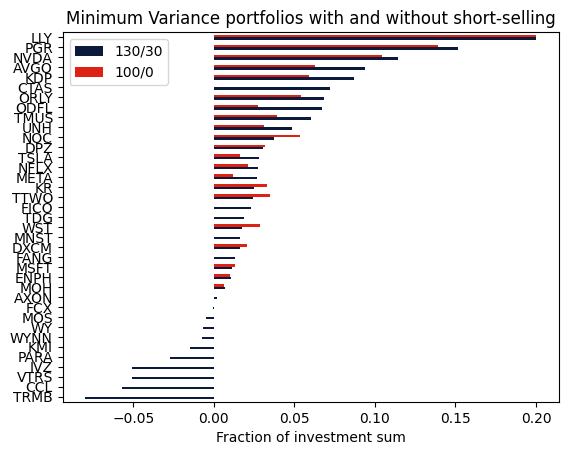

In [12]:
# adjust RHS of short constraint
short_constr.RHS = 0
m.params.OutputFlag = 0
m.optimize()

# retrieve and display solution data
mask = (abs(df["x"]) > 1e-5) | (x.X > 1e-5)
df2 = pd.DataFrame(
    index=df["x"][mask].index,
    data={
        "130/30": df["x"][mask],
        "100/0": x.X[mask],
    },
).sort_values(by=["130/30", "100/0"], ascending=True)

axs = df2.plot.barh(color=["#0b1a3c", "#dd2113"])
axs.set_xlabel("Fraction of investment sum")
plt.title("Minimum Variance portfolios with and without short-selling")
plt.show()

## Efficient Frontiers

The efficient frontier reveals the balance between risk and return in investment portfolios. It shows the best-expected return level that can be achieved for a specified risk level.
We compute this by solving the above optimization problem for a sample of admissible risk levels for four long/short strategies; 100/0 is the long-only strategy.
Note that to change the strategy in the model, we only need to update the right-hand side of constraint (2) above.

In [13]:
risks = np.linspace(1.5, 5, 20)
# risks = np.concatenate(([0], np.logspace(-5, 0, 7, endpoint=False), np.linspace(1, 4, 12)**2), axis=0)
# risks = np.concatenate(([0], np.sqrt(np.geomspace(1e-10, 32**2, 20))), axis=0)
strategies = [0, 0.1, 0.2, 0.3]

returns = pd.DataFrame(index=risks)

# hide Gurobi log output
m.params.OutputFlag = 0

for short in strategies:
    name = f"{int((1+short)*100)}/{int(short*100)}"
    # adjust RHSs in short constraint
    short_constr.RHS = short

    r = np.zeros(risks.shape)
    # solve the model for each risk level
    for i, risk_level in enumerate(risks):
        # set risk level: RHS of risk constraint
        risk_constr.QCRHS = risk_level**2

        m.optimize()
        # store data
        r[i] = m.ObjVal

    returns[name] = r

We can display the efficient frontiers for all strategies. We plot the expected returns (on the $y$-axis) against the standard deviation $\sqrt{x^\top\Sigma x}$ of the expected returns (on the $x$-axis).

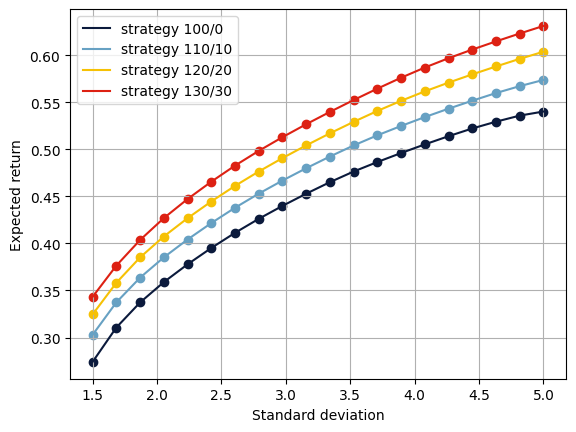

In [14]:
colors = ["#0b1a3c", "#67a1c3", "#f6c105", "#dd2113"]
fig, axs = plt.subplots()

for column, color in zip(returns.columns, colors):
    axs.scatter(x=returns.index, y=returns[column], marker="o", color=color)
    axs.plot(
        returns.index,
        returns[column],
        label=f"strategy {column}",
        color=color,
    )
axs.set_xlabel("Standard deviation")
axs.set_ylabel("Expected return")
axs.legend()
axs.grid()

plt.show()

## Takeaways

* Individual bounds on long and short positions can be modeled via variable bounds.
* Bounds on the total short ratio can be modeled using the negative parts of the positions.
* Including leverage and short-selling, the efficient frontier shifts significantly towards the return direction.
* Different strategies can be tested by modifying the right-hand sides; there is no need to rebuild the model.